In [131]:
%matplotlib inline

import numpy as np
import mplcyberpunk
import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
from matplotlib import rcParams

plt.style.use("cyberpunk")

rcParams["font.sans-serif"] = "Roboto"
rcParams["xtick.labelsize"] = 14.
rcParams["ytick.labelsize"] = 14.
rcParams["axes.labelsize"] = 14.
rcParams["legend.fontsize"] = 14
rcParams["axes.titlesize"] = 16.

In [8]:
np.random.seed(42)

_ = torch.manual_seed(42)

# Auxiliary Functions

This notebook is a compilation of a few aspects that are "secondary" to deep learning models. This provides a quick overview using PyTorch.

## Exponential Activation Functions

These activation functions all contain exponential functions, and so vary relatively smoothly with $x$. The general purpose of these functions is to compress output values such that they lie within a certain range, and eventually asymptote/saturate at some point. The sigmoid and tanh functions in particular are classic activation functions, but as you will see below, their derivatives go to zero quite quickly with larger values of $x$.

### Sigmoid

$$ \sigma(x) = \frac{1}{1 + \exp(-x)} $$

Collapses values to the range of [0,1]; used traditionally to mimic neurons firing, although saturates very easily with values of $x$ not near zero and so is less commonly used now between layers, but more for binary classification (0 or 1) or [Bernoulli trial.](https://en.wikipedia.org/wiki/Bernoulli_distribution)

### Softmax

$$ \mathrm{softmax}(x) = \frac{\exp(x)}{\sum \exp(x)} $$

Forces the vector to sum to 1 like probabilities of multiple independent events. Used commonly for multiclass classification, which outputs the likelihood of a given class.

### Softplus

$$ \mathrm{softplus}(x) = \frac{1}{\beta}\log(1 + \exp(\beta x))$$

### tanh

$$ \tanh(x) = \frac{\exp(x) - \exp(-x)}{\exp(x) + \exp(-x)} $$

/home/kelvin/anaconda3/envs/uml/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
/home/kelvin/anaconda3/envs/uml/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmin has been deprecated. Change the call to include dim=X as an argument.
  
/home/kelvin/anaconda3/envs/uml/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
/home/kelvin/anaconda3/envs/uml/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmin has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


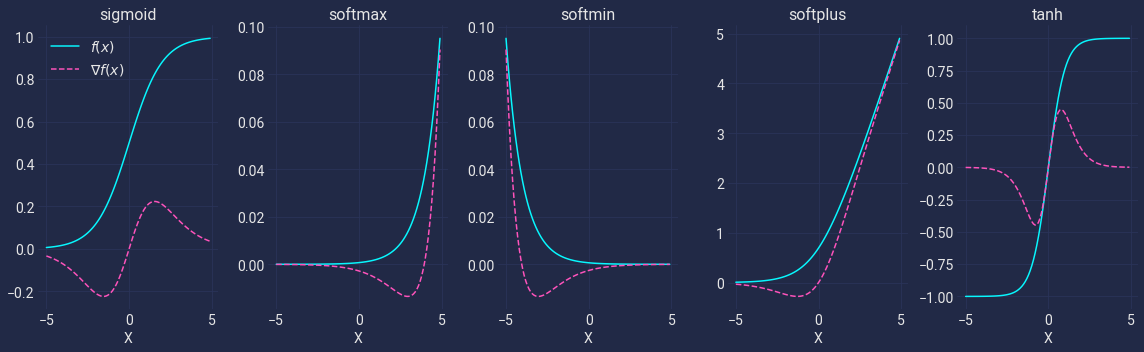

In [150]:
funcs = [torch.sigmoid,  F.softmax, F.softmin, F.softplus, torch.tanh]

fig, axarray = plt.subplots(1, len(funcs), figsize=(16,5.))

with torch.no_grad():
    for ax, func in zip(axarray, funcs):
        X = torch.arange(-5, 5., step=0.1)
        Y = func(X)
        ax.plot(X, Y, lw=1.5,  alpha=1., label="$f(x)$")
        ax.set_title(func.__name__)
        ax.set_xlabel("X")

# Compute gradients this time
for ax, func in zip(axarray, funcs):
    X = torch.autograd.Variable(torch.arange(-5, 5., step=0.1), requires_grad=True)
    Y = func(X)
    # take derivative of Y with respect to X. this is a bit more trouble
    # than usual because Y is not scalar and you can't call Y.backward()
    torch.autograd.backward([Y], [X])
    grads = X.grad
    ax.plot(X.detach(), grads.numpy(), lw=1.5,  alpha=1., label="$\\nabla f(x)$", ls="--")

axarray[0].legend(loc=2)
fig.tight_layout()

## "Linear" Activation Functions

### Rectified Linear Unit (ReLU)

$$ \mathrm{ReLU}(x) = \mathrm{max(0, x)} $$

Despite having little statistical interpretation (compared to sigmoid, for example), it works well for most tasks.

### Exponential Linear Unit (ELU)

$$ \mathrm{ELU}(x) = \mathrm{max}(0,x) + \mathrm{min}(0, \alpha \exp(x) - 1) $$

where $\alpha$ is a hyperparameter tuned to change the rate of change. Allows the gradient to be non-zero with small values of $x$, and only asymptotes at very negative values.

### Leaky ReLU

$$ \mathrm{LeakyReLU}(x) = \mathrm{max}(0,x) + \alpha \mathrm{min}(0,x) $$

where $\alpha$ is a hyperparameter tuned to allow some negative gradients backpropagate; otherwise they would asymptote to zero as in ReLU.

### ReLU6

$$ \mathrm{ReLU6}(x) = \mathrm{min}(\mathrm{max(0, x)}, 6) $$

### Scaled Exponential Linear Unit (SELU)

$$ \mathrm{SELU}(x) = \lambda \mathrm{max}(0, x) + \mathrm{min}(0,\alpha (\exp(x) - 1)) $$

where $\lambda$ and $\alpha$ are hyperparameters, although were numerically tuned to $\alpha=1.6733$ and $\lambda=1.0507$
for [self-normalizing neural networks](https://arxiv.org/pdf/1706.02515.pdf).

### Gaussian Error Linear Unit (GELU)

$$ \mathrm{GELU}(x) = x \Phi(x) $$

where $\Phi(x)$ is the cumulative distribution function for a standard Gaussian distribution. Allows for [self-regularization to a certain extent](https://arxiv.org/pdf/1606.08415.pdf) similar to dropouts.

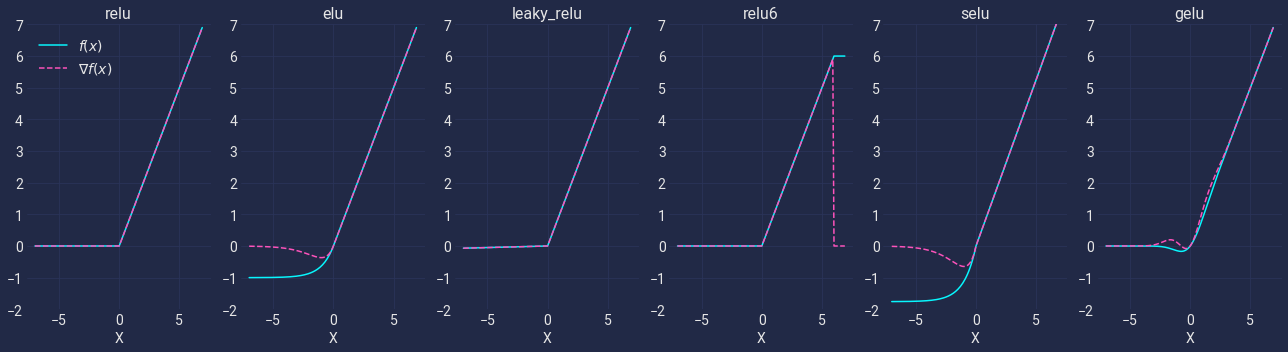

In [155]:
funcs = [F.relu,  F.elu, F.leaky_relu, F.relu6, torch.selu, F.gelu]

fig, axarray = plt.subplots(1, len(funcs), figsize=(18,5.))

with torch.no_grad():
    for ax, func in zip(axarray, funcs):
        X = torch.arange(-7, 7., step=0.1)
        Y = func(X)
        ax.plot(X, Y, lw=1.5,  alpha=1., label="$f(x)$")
        ax.set_title(func.__name__)
        ax.set_xlabel("X")

for ax, func in zip(axarray, funcs):
    X = torch.autograd.Variable(torch.arange(-7, 7., step=0.1), requires_grad=True)
    Y = func(X)
    torch.autograd.backward([Y], [X])
    grads = X.grad
    ax.plot(X.detach(), grads.numpy(), lw=1.5,  alpha=1., label="$\\nabla f(x)$", ls="--")
    ax.set_ylim([-2., 7.])

axarray[0].legend(loc=2)
fig.tight_layout()

## Loss functions